# Coleta do Dataset ERA-5 e INMET




In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import time
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from pyproj import Transformer
import torch
import matplotlib.pyplot as plt
import os
import shutil
import torch.nn as nn
from torch_geometric.nn import GCNConv, ChebConv
import torch.nn.functional as F
from torch.utils.data import Dataset
from Dataset_Utils import station_dictionary, grafo_distancias, tensor_data, reset_weights
torch.set_printoptions(threshold=100_000)
np.set_printoptions(threshold=np.inf)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
rea = xr.open_dataset(r'C:\Climate Change Project\Datasets\.nc files\era5_precipitation_80-26.nc')
catalogo_inmet = pd.read_csv(r'C:\Climate Change Project\Datasets\Dados INMET\CatalogoEstaçõesAutomáticas.csv', sep=';')
estacoes_RS = station_dictionary(catalogo_inmet)
edge_index, edge_weight = grafo_distancias(stations=estacoes_RS, criterion=120)
print("Dataset com "+str(rea.time.values.shape[0]/(2))+" dias")
N = 62

Dataset com 16826.5 dias


In [14]:
pos = {}
i=0
coords = np.zeros((N,2))
for name in estacoes_RS.keys():
    pos[i] = float(estacoes_RS[name][1]), float(estacoes_RS[name][0])
    coords[i] = [float(estacoes_RS[name][1]), float(estacoes_RS[name][0])]
    i+=1

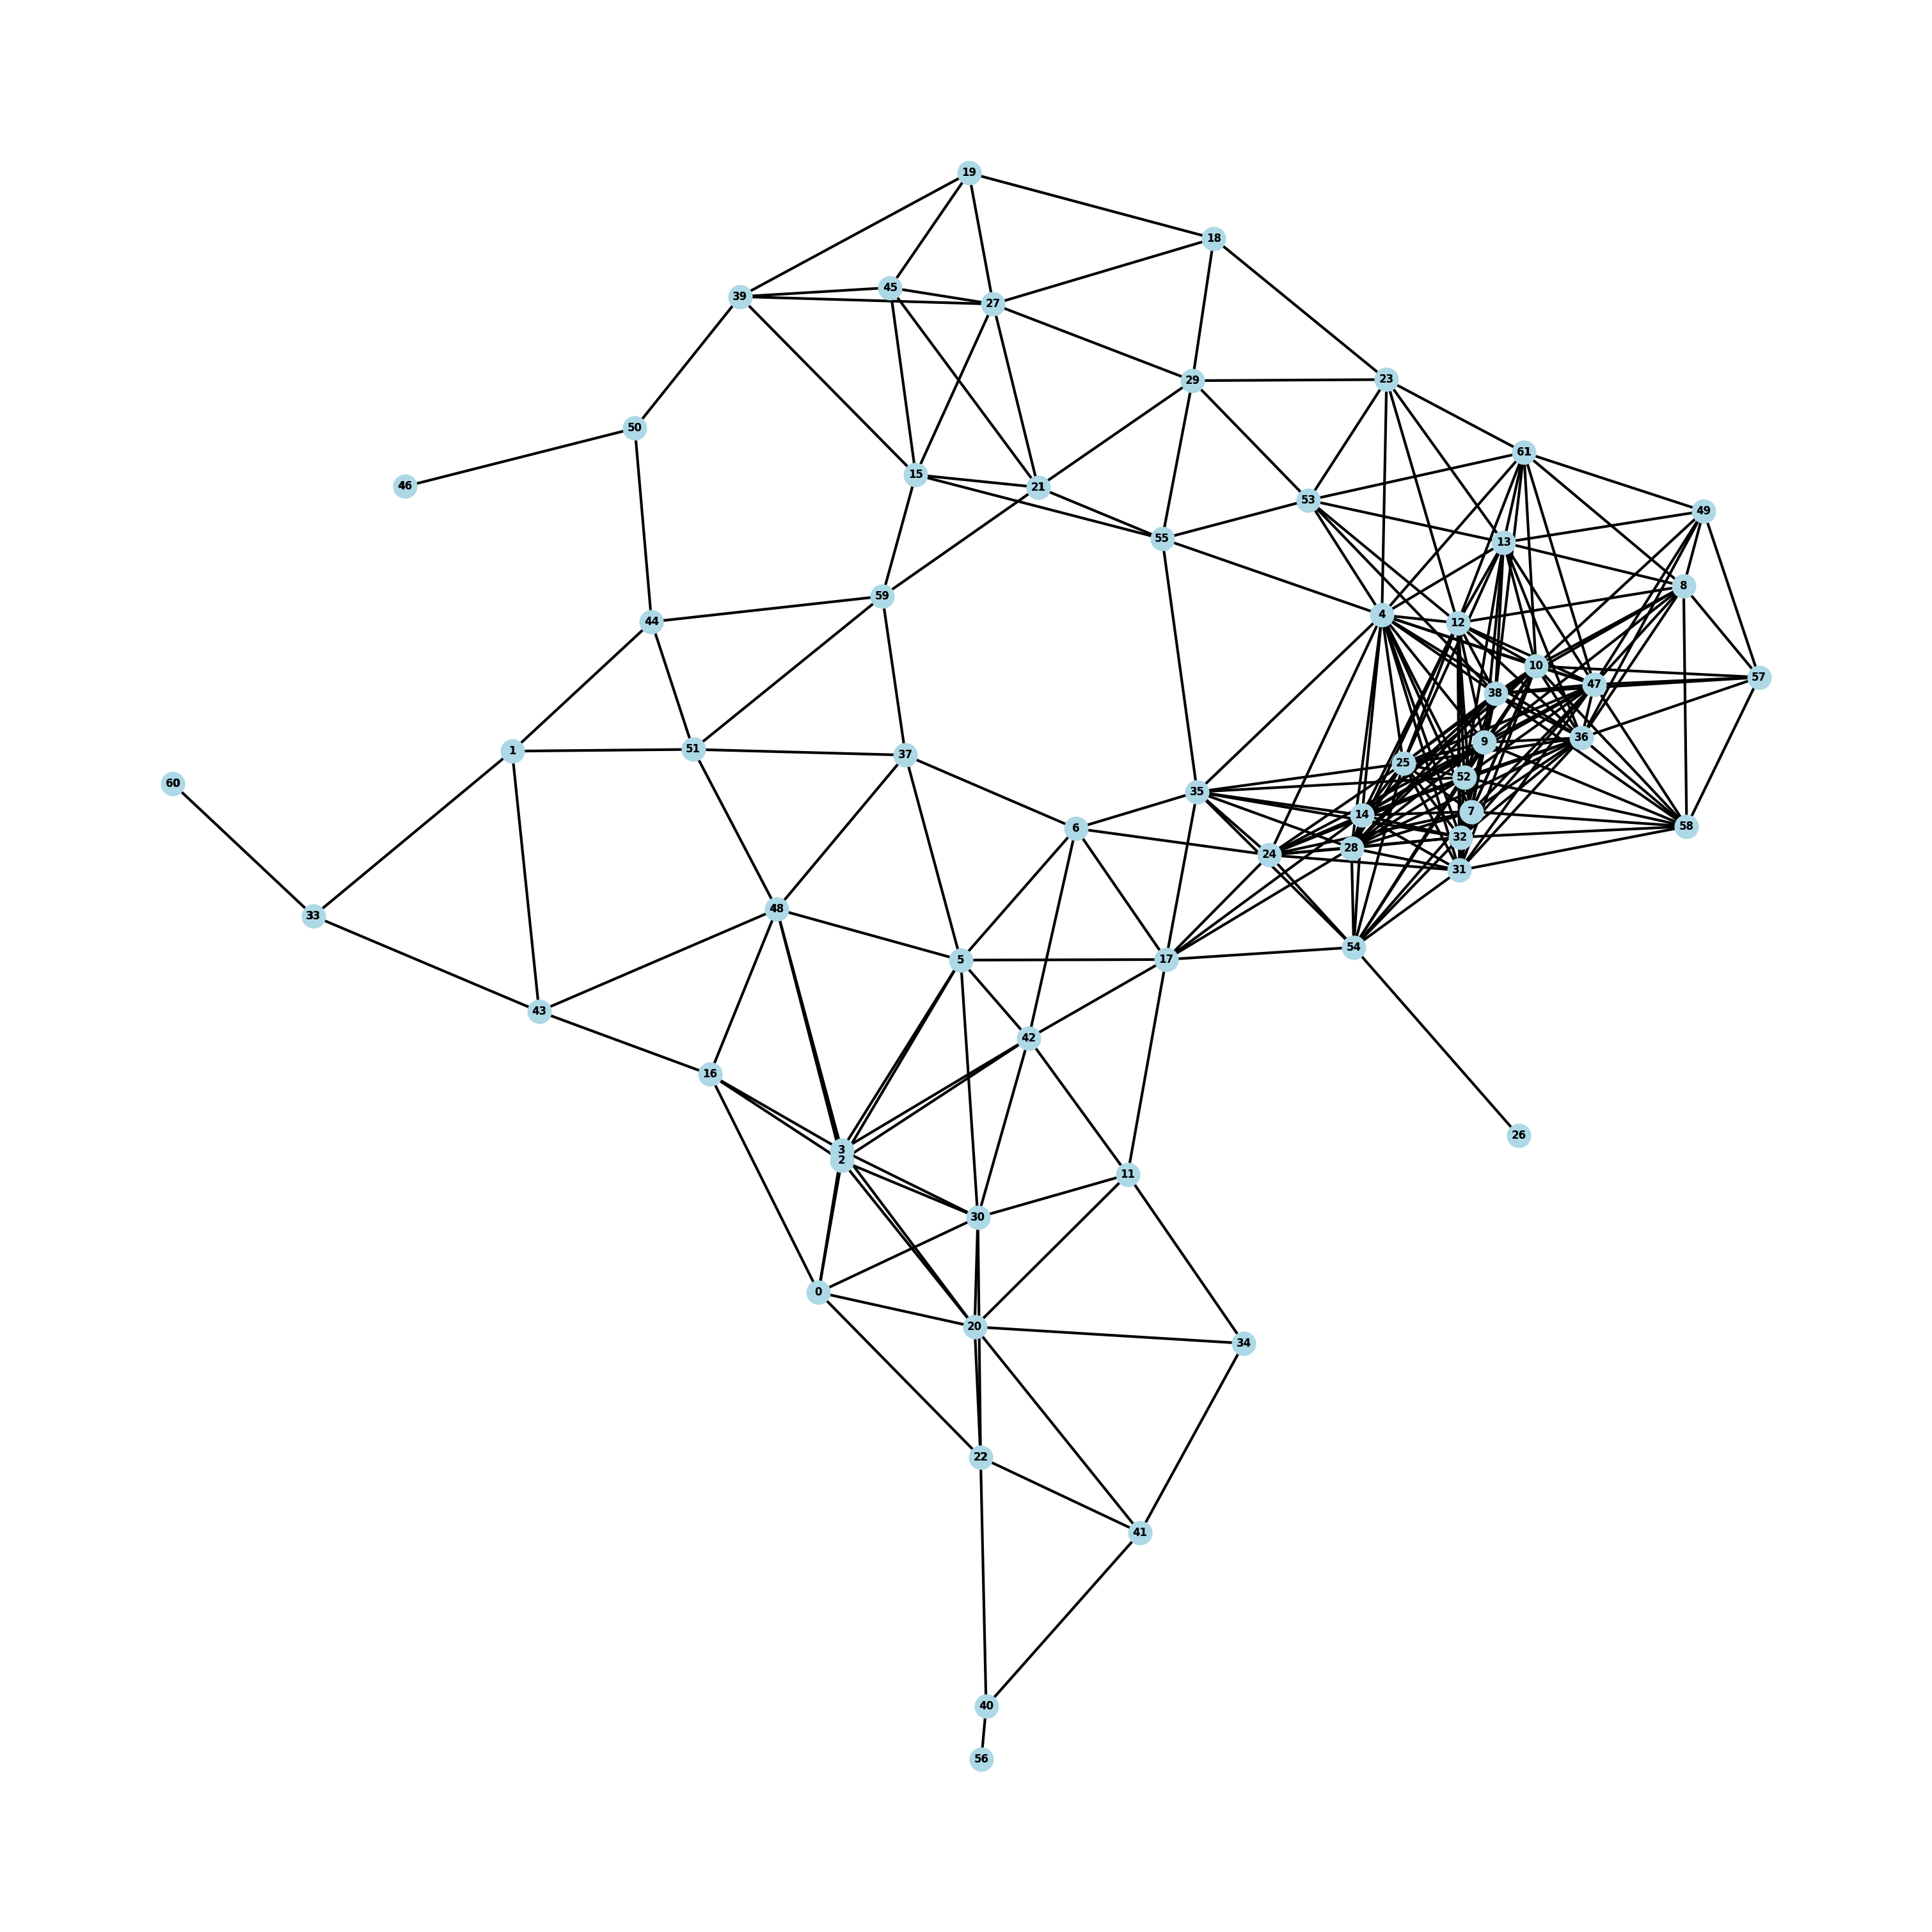

Construido grafo com  62 vértices


In [15]:
import matplotlib.pyplot as plt
transformer = Transformer.from_crs("EPSG:4326", "EPSG:31982", always_xy=True)
graph_data = Data(x=torch.zeros(62), edge_index=edge_index)


G = to_networkx(graph_data, to_undirected=True)

plt.figure(figsize=(30,30))
nx.draw(G,pos,
        with_labels=True,
        node_color='lightblue',
        node_size=700,
        width=3,
        font_weight='bold')



nx.draw_networkx_labels(G,pos,font_color='black')
plt.show()
print("Construido grafo com ",62,"vértices")



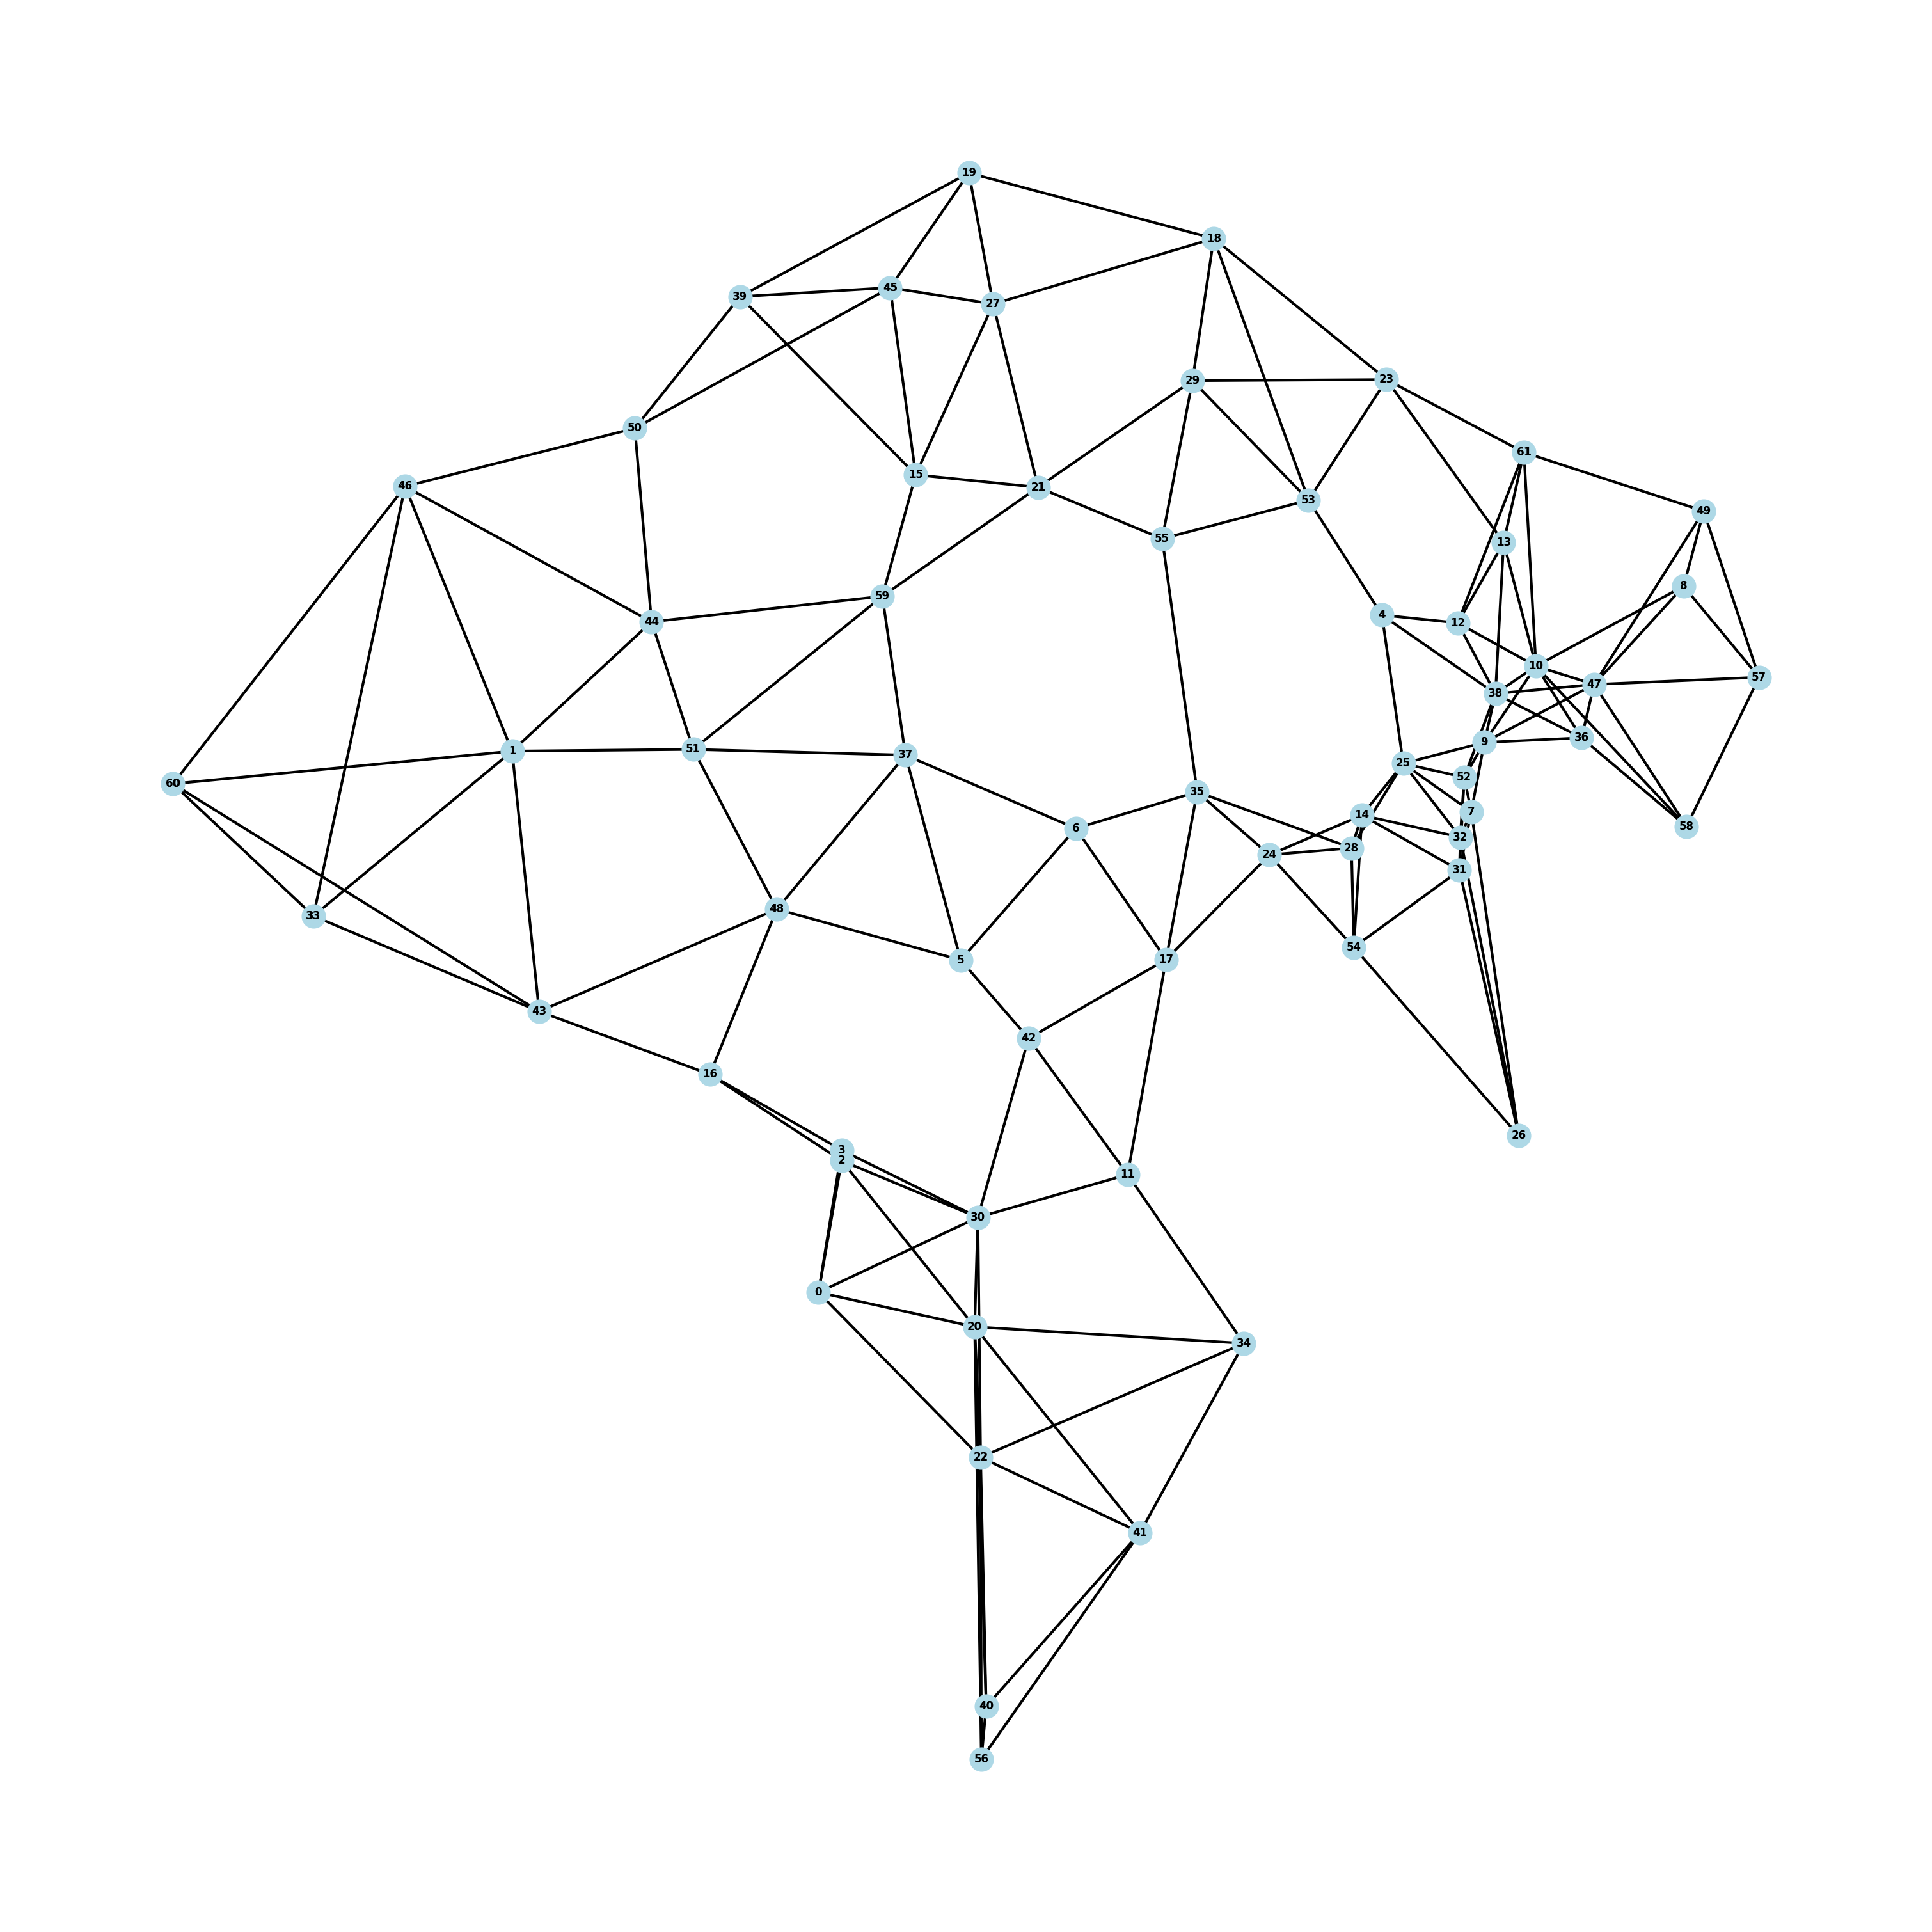

Construido grafo com  62 vértices


In [16]:
from sklearn.neighbors import NearestNeighbors

k = 4

nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
nbrs.fit(coords)

distances, indices = nbrs.kneighbors(coords)

E_1 = []
E_2 = []
for i in range(N):
    for j in indices[i][1:]:
        E_1.append(i)
        E_2.append(j)
        E_1.append(j)
        E_2.append(i)
edge_index_knn = torch.tensor([E_1,E_2],dtype=torch.int)


graph_data = Data(x=torch.zeros(62), edge_index=edge_index_knn)


G = to_networkx(graph_data, to_undirected=True)

plt.figure(figsize=(30,30))
nx.draw(G,pos,
        with_labels=True,
        node_color='lightblue',
        node_size=700,
        width=3,
        font_weight='bold')



nx.draw_networkx_labels(G,pos,font_color='black')
plt.show()
print("Construido grafo com ",N,"vértices")


In [73]:
#T = NÚMERO DE DIAS QUE SERÃO COLETADOS DO DATASET.NC DO ERA-5
#start_date = INICIO DOS DADOS QUE SERÃO ALIMENTADOS NA REDE

from tqdm import tqdm
start_date = "2015-01-01"
pbar = tqdm(total=100)
#pbar.close()
N = 62
t1 = pd.to_datetime(start_date)
T = 365*10
end_date = pd.to_datetime(start_date)+pd.Timedelta(days=T)

#Features de X: total precipitação, media7d, media14d, sazonalidade

X = torch.zeros((T,N,1))

print("Colhendo dados entre "+start_date+" e "+end_date.strftime("%Y-%m-%d")+" ...")


#COLETA DE DADOS DO DATASET DO ERA 5, CADA ITERAÇÃO COLETA UM DIA
#É POSSÍVEL PARALELIZAR MAS AINDA NÃO FOI IMPLEMENTADO
#ALI TAMBÉM TEM COMENTADO A CRIAÇÃO DAS MÉDIAS MOVEIS QUE COMENTEI SEXTA
#PARA ISSO PRECISA CONSIDERAR 14 DIAS PARA TRAS DO INICIO DO TREINO, PARA TER VALORES PARA FAZER A MEDIA
pbar.display()
for t in range(T):
    X[t,:,0] = 1000*tensor_data(t1+pd.Timedelta(days=t), t1+pd.Timedelta(days=t), rea, estacoes_RS).reshape(N)
    pbar.update(100/T)
    #if t>=14:
    #    X[t,:,1] = X[t-7:t,:,0].mean(dim=0)
    #    X[t,:,2] = X[t-14:t,:,0].mean(dim=0)
    #    X[t,:,3] = np.sin(np.pi*(t%365)/365)

pbar.close()

if X.isnan().any():
    print("Dataset com entradas NaN...")

  0%|          | 0.0273972602739726/100 [00:00<11:41,  7.02s/it]

Colhendo dados entre 2015-01-01 e 2024-12-29 ...


100%|█████████▉| 99.99999999999741/100 [12:04<00:00,  7.24s/it] 


In [75]:
#CALCULA O DIA BASEADO NO INDICE DO TENSOR X E DA DATA INCIAL DA COLETA
#UTIL PARA ANALISE POSTERIOR E PARA FUTUROS TESTES E PREVISÕES

def day_index(start_date, index):
    real_date = pd.to_datetime(start_date)+pd.Timedelta(days=index)
    return real_date

In [77]:
#CRIA O DATASET DE TREINO DA REDE, PEGANDO O TENSOR X
#E SEPARANDO EM BATCHS DE PERIOD-1 DIAS PARA FEATURES DE ENTRADA (Xs)
#E 1 DIA PARA TARGET (Ys)

def create_train_data(X, period):
    T = X.shape[0]
    Xs, ys = [], []
    for t in range(int(T/period)):
        Xs.append(X[t*period:t*period+period-1])
        ys.append(X[t*period+period-1])
    return torch.stack(Xs), torch.stack(ys)


#IMPLEMENTAR WINDOW DE PREVISÃO...
train_period = 20
Xs, ys = create_train_data(X, period=train_period)
Xs, ys = Xs[:,:,:,:1], ys[:,:,:1]

#LIMITE PARA FUTURAS PREVISÕES, NO CASO 10 BATCHS IRIAM 
#SER UTILIZADOS SINGLE E MULTI-STEP FORECAST
train_limit_index = Xs.shape[0]-10


print(Xs.shape, ys.shape)

torch.Size([182, 19, 62, 1]) torch.Size([182, 62, 1])


# Modelo de GNN com LSTM



In [78]:
import random

#DEFINE UMA MATRIZ DE ADJACENCIA COM PESOS 1/dist COM A DISTANCIA ENTRE AS ESTAÇÕES
#ESTA MATRIZ NO MODELO É CALIBRAVEL, ENTÃO A PRINCIPIO NO FINAL TEREMOS OUTRA MATRIZ (POSSÍVELMENTE NÃO SIMÉTRICA)
def adjacency_matrix(N, edge_index, edge_weight=None):
    A = torch.zeros((N,N))
    for i in range(0,len(edge_index[0]),2):
        u, v = edge_index[0][i], edge_index[0][i+1]
        A[u,v] = edge_weight[i]
        A[v,u] = edge_weight[i]
    return A


#print(adjacency_matrix(N, edge_index, edge_weight=edge_weight)[0])

In [ ]:
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F


class GLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, adj_matrix):
        super().__init__()
        self.hidden_size = hidden_size
        self.adj = nn.Parameter(adj_matrix)
        
        self.W_i = nn.Linear(input_size+hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size+hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size+hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size+hidden_size, hidden_size)
        
    def forward(self, x, h_prev, c_prev):
        
        #x             : (N, input_size)
        #h_prev/c_prev : (N, hidden_size)
        
        combined = torch.cat([x, h_prev], dim=-1)  # (N, input_size+hidden_size)
        
        combined_1 = torch.cat([x,torch.matmul(self.adj,h_prev)], dim=-1)
        
        #i, f, o, g : (N, input_size+hidden_size)
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined_1))
        g = torch.tanh(self.W_c(combined_1))
        
        c_t = f*c_prev+i*g
        c_graph = torch.matmul(self.adj, c_t) #(N, input_size+hidden_size)
        
        h_t = o*torch.tanh(c_graph)
        h_t = F.dropout(h_t, p=0.15, training=self.training)
        c_t = F.dropout(c_graph, p=0.15, training=self.training)
        return h_t, c_t
    
    
    
class GLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, adj_matrix=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList([GLSTMCell(input_size, hidden_size, adj_matrix) for _ in range(num_layers)])
        
    def forward(self, x_seq, edge_index=None):
        
        #x_seq : (T,N,F)
        
        T, N, _ = x_seq.shape
        h = [torch.zeros(N, self.hidden_size, device=x_seq.device) for _ in range(self.num_layers)]
        c = [torch.zeros(N, self.hidden_size, device=x_seq.device) for _ in range(self.num_layers)]
        
        outputs = []
        
        #IMPLEMENTAR NUMERO DE LAYERS MAIOR
        for t in range(T):
            ht, ct = self.cells[0](x_seq[t],h[0],c[0])
            h[0], c[0] = ht, ct
            outputs.append(ht)
        
        return torch.stack(outputs, dim=0) #(T, N, hidden_size)
        
        
        
class GNN_LSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_classes=1, num_nodes=62, num_layers=1,adj_matrix=None):
        super().__init__()
        self.node_emb = nn.Linear(input_dim, hidden_dim).to(device)
        self.num_nodes = num_nodes
        
        self.conv1 = GCNConv(hidden_dim, hidden_dim).to(device)
        self.conv2 = GCNConv(hidden_dim, hidden_dim).to(device)
        
        #self.chebconv1 = ChebConv(in_channels=hidden_dim, out_channels=hidden_dim, K=2)
        #self.chebconv2 = ChebConv(in_channels=hidden_dim, out_channels=hidden_dim, K=2)
        
        self.glstm = GLSTM(hidden_dim, hidden_dim, num_layers=num_layers, adj_matrix=adj_matrix)
        
        self.pool = global_mean_pool
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, num_classes),
            nn.Softplus()
        )
        
    def forward(self, x, edge_index):
        x.to(device)
        edge_index.to(device)
        T, N, _ = x.shape
        
        x = self.node_emb(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        T = x.shape[0]
        x_seq = x.view(T, self.num_nodes, -1)
        x_seq = self.glstm(x_seq, edge_index)
        
        #x_pooled = self.pool(x_seq[-1])
        
        out = self.fc(x_seq)
        return out

In [ ]:
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F

#CELULA DE GLSTM DESCRITA NO ARTIGO, POR ITERAÇÃO DE TEMPO RECEBE UM TENSOR X (feature, N) E OS ESTADOS OCULTOS H_prev E C_prev DA GLSTM DO TEMPO ANTERIOR
class GLSTMCell(nn.Module):
    def __init__(self, N, input_size, hidden_size, adj_matrix):
        super().__init__()
        self.hidden_size = hidden_size
        self.adj = nn.Parameter(adj_matrix).to(device)
        
        #MATRIZES DOS GATES DE INPUT, FORGET, OUTPUT E CELL-UPDATE QUE TRANSFORMA X
        self.W_i = nn.Linear(input_size, hidden_size)
        self.W_f = nn.Linear(input_size, hidden_size)
        self.W_o = nn.Linear(input_size, hidden_size)
        self.W_u = nn.Linear(input_size, hidden_size)
        
        #MATRIZES DOS GATES DE INPUT, FORGET, OUTPUT E CELL-UPDATE QUE TRANSFORMAM H_prev E H_prev*ADJACENCIA
        self.U_i = nn.Linear(hidden_size, hidden_size)
        self.U_f = nn.Linear(hidden_size, hidden_size)
        self.U_o = nn.Linear(hidden_size, hidden_size)
        self.U_u = nn.Linear(hidden_size, hidden_size)
    
        
    def forward(self, X, H_prev, C_prev):
        
        #X             : (input_size, N)
        #h_prev/c_prev : (hidden_size, N)
        
        

        
        #I, F, O, U : (hidden_size, N)
        H_graph = torch.matmul(H_prev, self.adj)
        C_graph = torch.matmul(C_prev, self.adj)

        I = torch.sigmoid(self.W_i(X)+self.U_i(H_graph.T)).T
        F = torch.sigmoid(self.W_f(X)+self.U_f(H_prev.T)).T
        O = torch.sigmoid(self.W_o(X)+self.U_o(H_graph.T)).T
        U = torch.tanh(self.W_u(X)+self.U_u(H_graph.T)).T
        
        #print(I.shape, F.shape, O.shape, U.shape)
        
        C_t = I*U + F*C_graph # (hidden_size, N)
        H_t = O*torch.tanh(C_t)


        return C_t, H_t #ambos de dimensão (hidden_size, N)
    
    
    
class GLSTM(nn.Module):
    def __init__(self, N, in_channels, hidden_size, num_layers=1, out_channels=1,adj_matrix=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.N = N
        self.cells = nn.ModuleList([GLSTMCell(N=N, input_size=in_channels, hidden_size=hidden_size, adj_matrix=adj_matrix) for _ in range(num_layers)])
        
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_size//2, out_channels),
            nn.Softplus()
        )
        
    def forward(self, x_seq, edge_index=None):
        
        #x_seq : (T,N,F)
        
        #F = in_channels
        
        T, N, _ = x_seq.shape
        H, C = torch.zeros((self.hidden_size,self.N), device=x_seq.device), torch.zeros((self.hidden_size, self.N), device=x_seq.device)
        
        #H = [torch.zeros(self.hidden_size,N, device=x_seq.device) for _ in range(self.num_layers)]
        #C = [torch.zeros(self.hidden_size,N, device=x_seq.device) for _ in range(self.num_layers)] #praticamente é sempre utilizado num_layers=1 (nem implementei multiplos layers de GLSTMCells...)
        
        outputs = []
        
        #IMPLEMENTAR NUMERO DE LAYERS MAIOR
        for t in range(T):
            #print("Step t=", t)
            H, C = self.cells[0](x_seq[t], H,C)
            # H, C : (hidden_size, N)
            outputs.append(H)
        
        outputs = torch.stack(outputs, dim=0) #(T, N, hidden_size)
        
        out = outputs[-1,:,:]
        
        out = out.T
        
        #print("saida do modelo com dimensão = ", out.shape)
    
        return self.fc(out)

In [83]:
#recria o folder de armazenamento dos dados da execução
test_counter = 0

path_folder = r"C:\Climate Change Project\Simulations_new_model"
if os.path.exists(path_folder):
    shutil.rmtree(path_folder)
os.mkdir(path_folder)

MSELoss()


In [ ]:
test_counter += 1
#CRIAR LOG DOS HIPERPARAMETROS DA REDE
#SALVAR AS LOSSES FINAIS (TREINO, VALIDAÇÃO, TESTE) PARA COMPARAÇÃO

edges = edge_index_knn.to(device)
N = 62
patience = 50
val_error = 0
epochs = 300
lr = 1e-2
weight_decay = 5e-4
hidden_dim = 64
num_layers = 1



MAE = nn.L1Loss()
MSE = nn.MSELoss()
loss_fn = nn.L1Loss()

T_train = Xs.shape[0]

print("Training period = "+str(start_date)+" to "+str(end_date))
path = path_folder+ r"\test_"+str(test_counter)+"-lr_"+str(lr)+"-epochs_"+str(epochs)+"-period_"+str(train_period)+"-hidden_dim_"+str(hidden_dim)+"-num_layers_"+str(num_layers)
dispersion_path = path +r"\dispersion"


if os.path.exists(path):
    shutil.rmtree(path)

os.mkdir(path)
os.mkdir(dispersion_path)

A = adjacency_matrix(N, edges, edge_weight)

model = GLSTM(N=N,in_channels=1, hidden_size=hidden_dim, num_layers=1, out_channels=1,adj_matrix=A).to(device)
model.apply(reset_weights)
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

for p in model.parameters():
    p.requires_grad = True

anomaly_dates = []
day_counter = 0
best_model = model.state_dict()
best_val_loss = float('inf')
val_loss = 0
counter = 0
station_counter = np.zeros((N, 2))
validation_temp = int(Xs.shape[0]*0.2)

tempo_inicio = time.time()
train_mse = []
val_mse = []
train_mape = []
val_mape = []
loss_fn_train = []
loss_fn_val = []



for t in range(T_train):
    if t%5==0 and t!=0:
        with torch.no_grad():
            X_validation = Xs[t].to(device)
            y_validation = ys[t].to(device)
            model.eval()
            y_pred = model(X_validation,edges).to(device)
            
            loss = loss_fn(y_pred.reshape(N),y_validation.reshape(N))
            mse = MSE(y_pred.reshape(N),y_validation.reshape(N))
            mape = MAE(y_pred.reshape(N),y_validation.reshape(N))
            
            val_mape.append(mape)
            val_mse.append(mse)
            loss_fn_val.append(loss.cpu())
            
            
            plt.figure(figsize=(5,5))
            plt.scatter(y_validation.cpu(),y_pred.cpu(),label="Dispersão",marker="x",c='Red')
            plt.plot([0,60],
                    [0,60],
                    linestyle="--")
            real_time = str(day_index(start_date, index=train_period*(t+1)))
            plt.savefig(dispersion_path+r"\(VAL)t="+str(t)+"_day_"+real_time[:10]+".png", format='png')
            plt.close()
            continue
        
    counter = 0
    val_loss = 0
    X_train = Xs[t].to(device)
    y_train = ys[t].to(device)
    
    best_val_loss = float('inf')
    
    #print(f"=====================BATCH {t}==============================")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        y_pred = model(X_train.to(device), edges.to(device))
        for name, param in model.named_parameters():
            if param.isnan().any():
                print("parametros NaN:", name)
        loss = loss_fn(y_pred.to(device).reshape(N), y_train.to(device).reshape(N))
        loss.backward()
        optimizer.step()
        val_loss = loss
        if val_loss<best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model = model.state_dict()
            model.load_state_dict(best_model)
        else:
           counter += 1
        if counter>patience:
            model.load_state_dict(best_model)
            print(str(t)+"early stopping na época "+str(epoch))
            break
        #if epoch%10==0 and epoch>1:
        #    print("LOSSS EPOCHS",loss)
        
    #diff = abs(y_pred[-1].to(device)- y_train.to(device))
    #max_error, min_error = diff.max(), diff.min()
    #i_max, i_min = torch.argmax(diff), torch.argmin(diff)
    #station_counter[i_min][0] += 1
    #station_counter[i_max][1] += 1
    #if val_loss>=1e+2:
    #    anomaly_dates.append(day_index(start_date,index=7*(t+1)))
    
    
    loss_fn_train.append(loss.detach().cpu())
    mse = MSE(y_pred.detach().cpu().reshape(N),y_train.cpu().reshape(N))
    train_mse.append(mse)
    train_mape.append(100*MAE(y_pred.to(device).reshape(N),y_train.to(device).reshape(N)).detach().cpu())
    
    
    plt.figure(figsize=(3,3))
    plt.scatter(y_train.detach().cpu(),y_pred.detach().cpu(),label="Dispersão",marker="x")
    plt.plot([0,60],
             [0,60],
             linestyle="--")
    real_time = str(day_index(start_date, index=train_period*(t+1)))
    plt.savefig(dispersion_path+r"\t="+str(t)+"_day_"+real_time[:10]+".png")
    plt.close()
    #print(f'Erro do treino batch ({t}) : {loss.detach():e}')


plt.figure(figsize=(40,20))
plt.plot(train_mse)
plt.ylim(0,200)
plt.grid(True)
plt.xticks([10*t for t in range(int(len(train_mse)/10))])
plt.title("MSE LOSS (TRAIN) \\ Tempo de Execução: "+str(time.time()-tempo_inicio))
plt.savefig(path+r"\\MSE_LOSS_TRAIN.svg", format="svg")
plt.show()

plt.figure(figsize=(40,20))
plt.plot(train_mape)
plt.ylim(0,200)
plt.grid(True)
plt.xticks([10*t for t in range(int(len(train_mape)/10))])
plt.title("MAPE LOSS (TRAIN) \\ Tempo de Execução: "+str(time.time()-tempo_inicio))
plt.savefig(path+r"\\MAPE_LOSS_TRAIN.svg", format="svg")
plt.show()

hiper_log =" epochs:"+str(epochs)+"\n hidden_dim:"+str(hidden_dim)+"\n patience:"+str(patience)+"\n weight_decay:"+str(weight_decay)+"\n lr:"+str(lr)+"\n Loss:"+str(loss_fn)

with open(path+r"\log_hiper_parametros.txt", "w") as file:
    file.write(hiper_log)

Training period = 2015-01-01 to 2024-12-29 00:00:00
2early stopping na época 74
3early stopping na época 275
4early stopping na época 193
6early stopping na época 56
7early stopping na época 225
11early stopping na época 100
12early stopping na época 80


In [74]:
model.train()
for name, p in model.named_parameters():
    if p.grad is None:
        print(name, "sem gradiente")
    if not p.requires_grad:
        print(name, "requires=False")